<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Get Your PDF Files AI-Ready

In this notebook, we will leverage **Instill VDP** pipelines hosted on the **Instill Cloud** platform to transform PDF files into high-quality Markdown formatted text, suitable for AI applications.

### Why Does This Matter?

If you are building an AI or ML system, the level of performance you can achieve is almost entirely determined by the quality of the data you use to build or train that system: **Garbage In** $=$ **Garbage Out**. Oftentimes, you may want to build AI systems, such as RAG assistants or fine-tuned LLMs, using the information contained in documents such as PDF files. Despite their abundance throughout almost all organizations, PDF files are notoriously difficult to parse accurately due to the diversity of layouts, embedded images, charts, and non-standard fonts.

### Why Markdown?

Markdown is an ideal format for AI applications because it offers a balance between simplicity and structure. It provides a lightweight, human-readable way to represent documents while preserving essential formatting elements like headings, lists, and links. Unlike raw text, Markdown captures the document's hierarchy and formatting in a clear, organized manner, making it easier for AI models to extract meaning and context. This structured format maximizes its utility for AI processing, enabling better performance in tasks like text summarization, document classification, and question answering.

### Flexibility Based on Document Complexity

There’s no one-size-fits-all solution for parsing PDF documents into Markdown because every document is different. Some may have simple text and formatting, while others include intricate tables, images, or specialized formatting like mathematical equations. A PDF could even be a scanned hand-written note. Depending on the complexity of the document, we provide multiple approaches, allowing you to choose the best method for your particular use case:

1. **Transform any document** (PDF/DOCX/DOC/PPTX/PPT/HTML/XLSX) into Markdown using the **Instill Component** [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown).
2. **PDF-to-Markdown conversion with LLM correction** using a [pipeline](https://instill.tech/george_strong/pipelines/llm-corrected-pdf-to-markdown/playground) that leverages a Large Language Model (LLM) to supervise and improve the formatting of Markdown output generated by the Document Operator.
3. **PDF-to-Markdown conversion with VLM correction** using a [pipeline](https://instill.tech/george_strong/pipelines/vlm-corrected-pdf-to-markdown/playground) that first converts pages to images, and then leverages a Visual Language Model (VLM) to supervise and improve the formatting of the Document Operator output using the images as context.

In this notebook, we will demonstrate how to use each of these methods via our Python SDK. The PDF document we will be demonstrating on is the famous [AlexNet paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk==0.11.0 --quiet

In [2]:
from IPython.display import IFrame

import base64
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt
import math
from concurrent.futures import ThreadPoolExecutor

from instill.clients.client import init_pipeline_client
pipeline = init_pipeline_client(api_token="YOUR_INSTILL_API_TOKEN")

Let's download and base64 encode the [AlexNet PDF](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) file we will be converting to Markdown-formatted text.

In [3]:
alexnet_paper = "https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf"

alexnet_response = requests.get(alexnet_paper)
alexnet_base64 = base64.b64encode(alexnet_response.content).decode('utf-8')

### 1. Instill Component Document Operator

First, we will transform the PDF file into Markdown using the **Instill Component** [Document Operator](https://www.instill.tech/docs/component/operator/document). This is the fastest, cheapest, and lowest latency option available. To implement this, we will be using the [standard-doc-to-markdown](https://instill.tech/george_strong/pipelines/standard-doc-to-markdown/playground) pipeline. 

In [4]:
response = pipeline.trigger_namespace_pipeline(
    "george_strong",
    "standard-doc-to-markdown",
    [{"file": alexnet_base64}]
)

In [5]:
def get_md(response):
    return response.outputs[0].fields['markdown'].string_value


md_text = get_md(response)
print(md_text)

# ImageNet   Classification with Deep Convolutional Neural Networks

   Alex Krizhevsky   Ilya Sutskever   Geoffrey E. Hinton
  University of Toronto University of Toronto University of Toronto
kriz@cs.utoronto.ca ilya@cs.utoronto.ca hinton@cs.utoronto.ca

                 Abstract

   We trained a large, deep convolutional neural network to classify the 1.2 million
   high-resolution images in the ImageNet LSVRC-2010 contest into the 1000 dif-
   ferent classes. On the test data, we achieved top-1 and top-5 error rates of 37.5%
   and 17.0% which is considerably better than the previous state-of-the-art. The
   neural network, which has 60 million parameters and 650,000 neurons, consists
   of five convolutional layers, some of which are followed by max-pooling layers,
   and three fully-connected layers with a final 1000-way softmax. To make train-
   ing faster, we used non-saturating neurons and a very efficient GPU implemen-
   tation of the convolution operation. To reduce overfi

In addition to the Markdown-formatted text output, the [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown) also outputs images that have been extracted.

In [6]:
def get_images(response):
    return response.outputs[0].fields['images'].list_value.values


images = get_images(response)

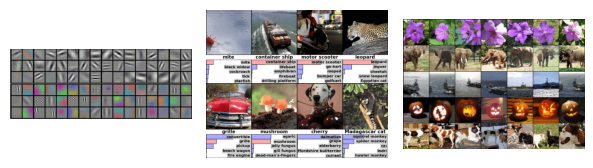

In [7]:
def plot_images(base64_strings, images_per_row=4):
    num_images = len(base64_strings)
    num_rows = math.ceil(num_images / images_per_row)

    plt.figure(figsize=(images_per_row * 2, num_rows * 2))

    for i, b64_str in enumerate(base64_strings):
        base64_data = b64_str.string_value.split(',')[1]

        image_data = base64.b64decode(base64_data)
        image = Image.open(io.BytesIO(image_data))

        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


plot_images(images, images_per_row=4)

### 2. PDF-to-Markdown conversion with LLM correction

We will now use the [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown) in tandem with a LLM whose task is to supervise and improve the formatting of Markdown output previously generated by the Document Operator. Checkout the pipeline Preview and README pages below for additional context.

In [19]:
IFrame('https://instill.tech/george_strong/pipelines/llm-corrected-pdf-to-markdown/preview', width=1000, height=700)

In [9]:
response = pipeline.trigger_namespace_pipeline(
    "george_strong",
    "llm-corrected-pdf-to-markdown",
    [{"file": alexnet_base64}]
)

In [10]:
md_text = get_md(response)
print(md_text)

# ImageNet Classification with Deep Convolutional Neural Networks

**Alex Krizhevsky**  
**Ilya Sutskever**  
**Geoffrey E. Hinton**  
University of Toronto  
kriz@cs.utoronto.ca  
ilya@cs.utoronto.ca  
hinton@cs.utoronto.ca  

## Abstract

We trained a large, deep convolutional neural network to classify the 1.2 million high-resolution images in the ImageNet LSVRC-2010 contest into 1000 different classes. On the test data, we achieved top-1 and top-5 error rates of 37.5% and 17.0%, which is considerably better than the previous state-of-the-art. The neural network, which has 60 million parameters and 650,000 neurons, consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax. To make training faster, we used non-saturating neurons and a very efficient GPU implementation of the convolution operation. To reduce overfitting in the fully-connected layers, we employed a recently-developed regulariz

### 3. PDF-to-Markdown conversion with VLM correction

In this approach, we use the [Document Operator](https://www.instill.tech/docs/component/operator/document) to convert the PDF file to Markdown-formatted text, alongside another document component that transforms each page into a separate image. A VLM is then instructed to supervise and improve the formatting of Markdown output previously generated by the Document Operator using the images as context.

For optimal performance, it is recommended that you only parse a couple of pages at a time when using this method. If this limit is exceeded, the VLM may struggle to adhere to all of the context provided in the images.

In [11]:
IFrame('https://instill.tech/george_strong/pipelines/vlm-corrected-pdf-to-markdown/preview', width=1000, height=700)

To break up the PDF into separate pages, we will use [PyMuPDF](https://pymupdf.readthedocs.io/en/latest/index.html).

In [12]:
!pip install pymupdf
import pymupdf

In [13]:
with open("alexnet_paper.pdf", 'wb') as f:
    f.write(alexnet_response.content)

In [14]:
pdf_document = pymupdf.open("alexnet_paper.pdf")
num_pages = len(pdf_document)
num_pages

9

To optimize performance, let's run each page separately through the pipeline by setting `group_size` to 1.

In [15]:
group_size = 1
encoded_groups = []

for i in range(0, num_pages, group_size):
    end_page = min(i + group_size, num_pages)

    pdf_writer = pymupdf.open()
    for page_num in range(i, end_page):
        pdf_writer.insert_pdf(pdf_document, from_page=page_num, to_page=page_num)
    
    pdf_bytes = io.BytesIO()
    pdf_writer.save(pdf_bytes)
    pdf_writer.close()
    
    encoded_pdf = base64.b64encode(pdf_bytes.getvalue()).decode('utf-8')
    encoded_groups.append(encoded_pdf)

Parse each page to Markdown in parallel using `ThreadPoolExecutor()` from Python's `concurrent.futures` module.

In [16]:
def process_group(encoded_group):
    return pipeline.trigger_namespace_pipeline(
        "george_strong",
        "vlm-corrected-pdf-to-markdown",
        [{"file": encoded_group}]
    )


with ThreadPoolExecutor() as executor:
    responses = list(executor.map(process_group, encoded_groups))

Merge each page back together to form a single Markdown-formatted text string.

In [17]:
md_text = ""

for response in responses:
    markdown_content = response.outputs[0].fields['markdown'].string_value
    md_text += markdown_content + "\n"

In [18]:
print(md_text)

# ImageNet Classification with Deep Convolutional Neural Networks

Alex Krizhevsky  
University of Toronto  
kriz@cs.utoronto.ca  

Ilya Sutskever  
University of Toronto  
ilya@cs.utoronto.ca  

Geoffrey E. Hinton  
University of Toronto  
hinton@cs.utoronto.ca  

## Abstract

We trained a large, deep convolutional neural network to classify the 1.2 million high-resolution images in the ImageNet LSVRC-2010 contest into the 1000 different classes. On the test data, we achieved top-1 and top-5 error rates of 37.5% and 17.0%, which is considerably better than the previous state-of-the-art. The neural network, which has 60 million parameters and 650,000 neurons, consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax. To make training faster, we used non-saturating neurons and a very efficient GPU implementation of the convolution operation. To reduce overfitting in the fully-connected layers, 